In [1]:
# Standard library imports
import logging
import time
import os
from datetime import datetime, timedelta
from pathlib import Path

# Set up logger"
logger = logging.getLogger(__name__)
logger.info("‚úÖ Standard library imports complete")

In [2]:
# Core data science libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

logger.info("‚úÖ Data science libraries loaded")

In [3]:
# Geospatial libraries
import rasterio
import xarray as xr
import rioxarray
from pystac_client import Client
import planetary_computer as pc
from shapely.geometry import box

logger.info("‚úÖ Geospatial libraries loaded")

In [4]:
# Interactive mapping
import folium
from folium.plugins import MeasureControl, Fullscreen

logger.info("‚úÖ Mapping libraries loaded")

In [5]:
# Import ALL helper functions from tangled Week 1 module
from geogfm.c01 import (
    # Environment and authentication (Section 2.1-2.4.1)
    verify_environment,
    setup_planetary_computer_auth,
    configure_gdal_environment,
    
    # Data discovery (Section 2.4.2)
    search_sentinel2_scenes,
    search_STAC_scenes,
    
    # Data loading (Section 2.4.3)
    load_sentinel2_bands,
    
    # Spatial processing (Section 2.4.4)
    get_subset_from_scene,
    get_scene_info,
    create_scene_tiles,
    test_subset_functionality,
    
    # Data processing (Section 2.4.5)
    normalize_band,
    create_rgb_composite,
    calculate_ndvi,
    calculate_band_statistics,
    
    # Visualization (Section 2.4.6)
    plot_band_comparison,
    
    # Export/Import (Section 2.4.7)
    save_geotiff,
    export_analysis_results,
    load_week1_data
)

logger.info("‚úÖ Week 1 helper functions imported")

2025-10-09 13:22:10,659 - INFO - Analysis results exported to: /home/caylor/GEOG-288KC-geospatial-foundation-models/week1_output
2025-10-09 13:22:10,660 - INFO - Data exported - use load_week1_data() to reload
2025-10-09 13:22:10,661 - INFO - ‚úÖ Week 1 helper functions imported


In [6]:
# Configure matplotlib for publication-quality plots
plt.rcParams.update({
    'figure.figsize': (10, 6),
    'figure.dpi': 100,
    'font.size': 10,
    'axes.titlesize': 12,
    'axes.labelsize': 10,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'legend.fontsize': 9
})

logger.info("‚úÖ Matplotlib configured")

2025-10-09 13:22:10,667 - INFO - ‚úÖ Matplotlib configured


In [7]:
# Configure GDAL/PROJ environment
gdal_config = configure_gdal_environment()

# Report configuration status
if gdal_config['proj_configured'] and gdal_config['gdal_configured']:
    logger.info("‚úÖ GDAL/PROJ fully configured and ready")
elif gdal_config['proj_configured'] or gdal_config['gdal_configured']:
    logger.warning("‚ö†Ô∏è Partial GDAL/PROJ configuration - some operations may fail")
    for warning in gdal_config['warnings']:
        logger.warning(warning)
else:
    logger.error("‚ùå GDAL/PROJ configuration incomplete")
    logger.error("This may cause issues with coordinate transformations")
    for warning in gdal_config['warnings']:
        logger.error(warning)

2025-10-09 13:22:10,745 - INFO - PROJ configured: /usr/share/proj
2025-10-09 13:22:10,748 - INFO - GDAL_DATA configured: /home/g288kc/miniforge/envs/geoAI/share/gdal
2025-10-09 13:22:10,750 - INFO - ‚úÖ GDAL/PROJ fully configured and ready


In [8]:
# Connect to STAC catalog
try:
    catalog = Client.open(
        "https://planetarycomputer.microsoft.com/api/stac/v1",
        modifier=pc.sign_inplace
    )

    logger.info("Connected to Planetary Computer STAC API")

    # Get catalog information
    try:
        catalog_info = catalog.get_self()
        logger.info(f"Catalog: {catalog_info.title}")
    except Exception:
        logger.info("Basic connection successful")

    # Explore key satellite datasets
    satellite_collections = {
        'sentinel-2-l2a': 'Sentinel-2 Level 2A (10m optical)',
        'landsat-c2-l2': 'Landsat Collection 2 Level 2 (30m optical)',
        'sentinel-1-grd': 'Sentinel-1 SAR (radar)',
        'naip': 'NAIP (1m aerial imagery)'
    }

    available_collections = []
    for collection_id, description in satellite_collections.items():
        try:
            collection = catalog.get_collection(collection_id)
            available_collections.append(collection_id)
            logger.info(f"Available: {description}")
        except Exception:
            logger.warning(f"Not accessible: {description}")

    logger.info(f"Accessible collections: {len(available_collections)}/{len(satellite_collections)}")

except Exception as e:
    logger.error(f"\nSTAC connection failed: {str(e)}")

2025-10-09 13:22:11,409 - INFO - Connected to Planetary Computer STAC API
2025-10-09 13:22:11,411 - INFO - Basic connection successful
2025-10-09 13:22:12,606 - INFO - Available: Sentinel-2 Level 2A (10m optical)
2025-10-09 13:22:12,814 - INFO - Available: Landsat Collection 2 Level 2 (30m optical)
2025-10-09 13:22:13,075 - INFO - Available: Sentinel-1 SAR (radar)
2025-10-09 13:22:13,276 - INFO - Available: NAIP (1m aerial imagery)
2025-10-09 13:22:13,277 - INFO - Accessible collections: 4/4


In [9]:
# Step 3A: Define Area of Interest with Geographic Reasoning
# Primary study area: Santa Barbara Region
# Coordinates chosen to encompass the greater Santa Barbara County coastal region
santa_barbara_bbox = [-120.5, 34.3, -119.5, 34.7]  # [west, south, east, north]

# Import required libraries for spatial calculations
from shapely.geometry import box
import os

# Create geometry object for area calculations
aoi_geom = box(*santa_barbara_bbox)

# Calculate basic spatial metrics
area_degrees = aoi_geom.area
# Approximate conversion to kilometers (valid for mid-latitudes)
center_lat = (santa_barbara_bbox[1] + santa_barbara_bbox[3]) / 2
lat_correction = np.cos(np.radians(center_lat))
area_km2 = area_degrees * (111.32 ** 2) * lat_correction  # 1 degree ‚âà 111.32 km

logger.info(f"AOI: Santa Barbara County ({area_km2:.0f} km¬≤)")

# Provide alternative study areas for different research interests
alternative_aois = {
    "San Francisco Bay Area": {
        "bbox": [-122.5, 37.3, -121.8, 38.0],
        "focus": "Urban growth, water dynamics, mixed land use",
        "challenges": "Fog and cloud cover in summer"
    },
    "Los Angeles Basin": {
        "bbox": [-118.7, 33.7, -118.1, 34.3],
        "focus": "Urban heat islands, air quality, sprawl patterns",
        "challenges": "Frequent clouds, complex topography"
    },
    "Central Valley Agriculture": {
        "bbox": [-121.5, 36.0, -120.0, 37.5],
        "focus": "Crop monitoring, irrigation patterns, drought",
        "challenges": "Seasonal variations, haze"
    },
    "Channel Islands": {
        "bbox": [-120.5, 33.9, -119.0, 34.1],
        "focus": "Island ecology, marine-terrestrial interface, conservation",
        "challenges": "Marine layer, limited ground truth"
    }
}

2025-10-09 13:22:13,295 - INFO - AOI: Santa Barbara County (4085 km¬≤)


In [10]:
# Step 3B: Create Interactive Map with Multiple Basemap Options
# Calculate map center for optimal display
center_lat = (santa_barbara_bbox[1] + santa_barbara_bbox[3]) / 2
center_lon = (santa_barbara_bbox[0] + santa_barbara_bbox[2]) / 2

# Initialize folium map with appropriate zoom level
# Zoom level chosen to show entire AOI while maintaining detail
m = folium.Map(
    location=[center_lat, center_lon],
    zoom_start=9,  # Optimal for metropolitan area viewing
    tiles='OpenStreetMap'
)

# Add diverse basemap options for different analysis contexts
basemap_options = {
    'CartoDB positron': {
        'layer': folium.TileLayer('CartoDB positron', name='Clean Basemap'),
        'use_case': 'Data overlay visualization, presentations'
    },
    'CartoDB dark_matter': {
        'layer': folium.TileLayer('CartoDB dark_matter', name='Dark Theme'),
        'use_case': 'Night mode, reducing eye strain'
    },
    'Esri World Imagery': {
        'layer': folium.TileLayer(
            tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
            attr='Esri', name='Satellite Imagery', overlay=False, control=True
        ),
        'use_case': 'Ground truth validation, visual interpretation'
    },
    'OpenTopoMap': {
        'layer': folium.TileLayer(
            tiles='https://{s}.tile.opentopomap.org/{z}/{x}/{y}.png',
            name='Topographic (OpenTopoMap)',
            attr='Map data: ¬© OpenStreetMap contributors, SRTM | Map style: ¬© OpenTopoMap (CC-BY-SA)',
            overlay=False,
            control=True
        ),
        'use_case': 'Elevation context, watershed analysis'
    }
}

for name, info in basemap_options.items():
    info['layer'].add_to(m)

# Add AOI boundary with informative styling
aoi_bounds = [[santa_barbara_bbox[1], santa_barbara_bbox[0]],  # southwest corner
              [santa_barbara_bbox[3], santa_barbara_bbox[2]]]  # northeast corner

folium.Rectangle(
    bounds=aoi_bounds,
    color='red',
    weight=3,
    fill=True,
    fillOpacity=0.1,
    popup=folium.Popup(
        f"""
        <div style="font-family: Arial; width: 300px;">
        <h4>üìä Study Area Details</h4>
        <b>Region:</b> Santa Barbara County Coastal Region<br>
        <b>Coordinates:</b> {santa_barbara_bbox}<br>
        <b>Area:</b> {area_km2:.0f} km¬≤<br>
        <b>Purpose:</b> Geospatial AI Training<br>
        <b>Data Type:</b> Sentinel-2 Optical<br>
        </div>
        """,
        max_width=350
    ),
    tooltip="Study Area Boundary - Click for details"
).add_to(m)

# Add geographic reference points with contextual information
reference_locations = [
    {
        "name": "Santa Barbara",
        "coords": [34.4208, -119.6982],
        "description": "Coastal city, urban-wildland interface",
        "icon": "building",
        "color": "blue"
    },
    {
        "name": "UCSB",
        "coords": [34.4140, -119.8489],
        "description": "University campus, research facilities",
        "icon": "graduation-cap",
        "color": "green"
    },
    {
        "name": "Goleta",
        "coords": [34.4358, -119.8276],
        "description": "Tech corridor, agricultural transition zone",
        "icon": "microchip",
        "color": "purple"
    },
    {
        "name": "Montecito",
        "coords": [34.4358, -119.6376],
        "description": "Wildfire-prone, high-value urban area",
        "icon": "fire",
        "color": "red"
    }
]

for location in reference_locations:

    folium.Marker(
        location=location["coords"],
        popup=folium.Popup(
            f"""
            <div style="font-family: Arial;">
            <h4>{location['name']}</h4>
            <b>Coordinates:</b> {location['coords'][0]:.4f}, {location['coords'][1]:.4f}<br>
            <b>Context:</b> {location['description']}<br>
            <b>Role in Analysis:</b> Geographic reference point
            </div>
            """,
            max_width=250
        ),
        tooltip=f"{location['name']} - {location['description']}",
        icon=folium.Icon(
            color=location['color'],
            icon=location['icon'],
            prefix='fa'
        )
    ).add_to(m)

# Add measurement and interaction tools for analysis

# Measurement tool for distance/area calculations
from folium.plugins import MeasureControl
measure_control = MeasureControl(
    primary_length_unit='kilometers',
    primary_area_unit='sqkilometers',
    secondary_length_unit='miles',
    secondary_area_unit='sqmiles'
)
m.add_child(measure_control)
logger.debug("Added measurement tool for distance/area calculations")

# Fullscreen capability for detailed examination
from folium.plugins import Fullscreen
Fullscreen(
    position='topright',
    title='Full Screen Mode',
    title_cancel='Exit Full Screen',
    force_separate_button=True
).add_to(m)
logger.debug("Added fullscreen mode capability")

# Layer control for basemap switching
layer_control = folium.LayerControl(
    position='topright',
    collapsed=False
)
layer_control.add_to(m)

# Display the map
m

In [11]:
# Step 4A: Implement Robust Multi-Strategy Scene Discovery
from datetime import datetime, timedelta

# Strategy 1: Dynamic temporal window based on current date
current_date = datetime.now()
# Define multiple search strategies with different trade-offs
# Each strategy balances data quality against data availability
search_strategies = [
    {
        "name": "Optimal Quality",
        "date_range": "2024-06-01/2024-09-30",
        "cloud_max": 20,
        "description": "Recent summer data with excellent atmospheric conditions",
        "priority": "Best for analysis quality",
        "trade_offs": "May have limited availability"
    },
    {
        "name": "Good Quality",
        "date_range": "2024-03-01/2024-08-31",
        "cloud_max": 35,
        "description": "Extended seasonal window with good conditions",
        "priority": "Balance of quality and availability",
        "trade_offs": "Some atmospheric interference"
    },
    {
        "name": "Acceptable Quality",
        "date_range": "2023-09-01/2024-11-30",
        "cloud_max": 50,
        "description": "Broader temporal and quality window",
        "priority": "Reliable data availability",
        "trade_offs": "May require additional preprocessing"
    },
    {
        "name": "Fallback Option",
        "date_range": "2023-01-01/2024-12-31",
        "cloud_max": 75,
        "description": "Maximum temporal window, relaxed quality constraints",
        "priority": "Guaranteed data access",
        "trade_offs": "Significant cloud contamination possible"
    }
]

# Execute search strategies in order of preference
scenes = []
successful_strategy = None

for i, strategy in enumerate(search_strategies, 1):
    try:
        # Use our optimized search function with current strategy parameters
        temp_scenes = search_sentinel2_scenes(
            bbox=santa_barbara_bbox,
            date_range=strategy["date_range"],
            cloud_cover_max=strategy["cloud_max"],
            limit=100  # Generous limit for selection flexibility
        )

        if temp_scenes:
            scenes = temp_scenes
            successful_strategy = strategy
            break

    except Exception as e:
        logger.warning(f"Search failed for {strategy['name']}: {str(e)[:80]}")
        continue

# Validate search results
if not scenes:
    logger.error(f"Scene discovery failed after trying all {len(search_strategies)} strategies")
    raise Exception("Critical failure in scene discovery")

2025-10-09 13:22:15,590 - INFO - Found 40 Sentinel-2 scenes (cloud cover < 20%)


In [12]:
# Step 4B: Intelligent Scene Selection Based on Multiple Quality Criteria
# Sort scenes by multiple quality criteria
# Primary: cloud cover (lower is better)
# Secondary: date (more recent is better)
scenes_with_scores = []

for scene in scenes:
    props = scene.properties

    # Extract key quality metrics
    cloud_cover = props.get('eo:cloud_cover', 100)
    date_str = props.get('datetime', '').split('T')[0]
    scene_date = datetime.strptime(date_str, '%Y-%m-%d')
    days_old = (current_date - scene_date).days

    # Calculate composite quality score (lower is better)
    # Weight factors: cloud cover (70%), recency (30%)
    cloud_score = cloud_cover  # 0-100 scale
    recency_score = min(days_old / 30, 100)  # Normalize to 0-100, cap at 100
    quality_score = (0.7 * cloud_score) + (0.3 * recency_score)

    scene_info = {
        'scene': scene,
        'date': date_str,
        'cloud_cover': cloud_cover,
        'days_old': days_old,
        'quality_score': quality_score,
        'tile_id': props.get('sentinel:grid_square', 'Unknown'),
        'platform': props.get('platform', 'Sentinel-2')
    }

    scenes_with_scores.append(scene_info)

# Sort by quality score (best first)
scenes_with_scores.sort(key=lambda x: x['quality_score'])

# Display top candidates for educational purposes
logger.info("Top 5 Scene Candidates (ranked by quality score):")
for i, scene_info in enumerate(scenes_with_scores[:5], 1):
    logger.debug(f"{i}. {scene_info['date']} - Cloud: {scene_info['cloud_cover']:.1f}%, Age: {scene_info['days_old']} days, Score: {scene_info['quality_score']:.1f}")
    if i == 1:
        logger.info(f"Selected optimal scene: {scene_info['date']}")

# Select the best scene
best_scene_info = scenes_with_scores[0]
best_scene = best_scene_info['scene']

logger.info(f"Optimal scene selected: {best_scene_info['date']} ({best_scene_info['cloud_cover']:.1f}% cloud cover, {best_scene_info['platform']}, Tile: {best_scene_info['tile_id']})")

# Validate scene completeness for required analysis
logger.info("Validating scene data completeness")
required_bands = ['B02', 'B03', 'B04', 'B08']  # Blue, Green, Red, NIR
available_bands = list(best_scene.assets.keys())
spectral_bands = [b for b in available_bands if b.startswith('B') and len(b) <= 3]

logger.debug(f"Available spectral bands: {len(spectral_bands)}, Required: {required_bands}")

missing_bands = [b for b in required_bands if b not in available_bands]
if missing_bands:
    logger.warning(f"Missing critical bands: {missing_bands} - this may limit analysis capabilities")

    # Check for alternative bands
    alternative_mapping = {'B02': 'blue', 'B03': 'green', 'B04': 'red', 'B08': 'nir'}
    alternatives_found = []
    for missing in missing_bands:
        alt_name = alternative_mapping.get(missing, missing.lower())
        if alt_name in available_bands:
            alternatives_found.append((missing, alt_name))

    if alternatives_found:
        logger.info(f"Found alternative band names: {alternatives_found}")
else:
    logger.info("All required bands available")

# Additional quality checks
extra_bands = [b for b in spectral_bands if b not in required_bands]
if extra_bands:
    logger.debug(f"Bonus bands available: {extra_bands[:5]}{'...' if len(extra_bands) > 5 else ''} (enable advanced spectral analysis)")

logger.info("Scene validation complete - ready for data loading")

# Quick connectivity test using our helper function
logger.info("Performing pre-flight connectivity test")
connectivity_test = test_subset_functionality(best_scene)

if connectivity_test:
    logger.info("Data access confirmed - all systems ready")
else:
    logger.warning("Connectivity issues detected - will attempt full download with fallback mechanisms")

2025-10-09 13:22:15,603 - INFO - Top 5 Scene Candidates (ranked by quality score):
2025-10-09 13:22:15,605 - INFO - Selected optimal scene: 2024-08-13
2025-10-09 13:22:15,606 - INFO - Optimal scene selected: 2024-08-13 (0.0% cloud cover, Sentinel-2B, Tile: Unknown)
2025-10-09 13:22:15,607 - INFO - Validating scene data completeness
2025-10-09 13:22:15,608 - INFO - All required bands available
2025-10-09 13:22:15,609 - INFO - Scene validation complete - ready for data loading
2025-10-09 13:22:15,610 - INFO - Performing pre-flight connectivity test
2025-10-09 13:22:21,788 - INFO - Successfully loaded 1 bands: ['B04']
2025-10-09 13:22:21,790 - INFO - Data access confirmed - all systems ready


In [13]:
# Step 4C: Comprehensive Scene and Sensor Characterization
if 'best_scene' in locals():
    scene_props = best_scene.properties
    scene_assets = best_scene.assets

    # Sentinel-2 spectral band specifications with AI applications
    sentinel2_bands = {
        'B01': {
            'name': 'Coastal/Aerosol',
            'wavelength': '443 nm',
            'resolution': '60m',
            'ai_applications': 'Atmospheric correction, aerosol detection'
        },
        'B02': {
            'name': 'Blue',
            'wavelength': '490 nm',
            'resolution': '10m',
            'ai_applications': 'Water body detection, urban classification'
        },
        'B03': {
            'name': 'Green',
            'wavelength': '560 nm',
            'resolution': '10m',
            'ai_applications': 'Vegetation health, true color composites'
        },
        'B04': {
            'name': 'Red',
            'wavelength': '665 nm',
            'resolution': '10m',
            'ai_applications': 'Vegetation stress, NDVI calculation'
        },
        'B05': {
            'name': 'Red Edge 1',
            'wavelength': '705 nm',
            'resolution': '20m',
            'ai_applications': 'Vegetation analysis, crop type classification'
        },
        'B06': {
            'name': 'Red Edge 2',
            'wavelength': '740 nm',
            'resolution': '20m',
            'ai_applications': 'Advanced vegetation indices, stress detection'
        },
        'B07': {
            'name': 'Red Edge 3',
            'wavelength': '783 nm',
            'resolution': '20m',
            'ai_applications': 'Vegetation biophysical parameters'
        },
        'B08': {
            'name': 'NIR (Near Infrared)',
            'wavelength': '842 nm',
            'resolution': '10m',
            'ai_applications': 'Biomass estimation, water/land separation'
        },
        'B8A': {
            'name': 'NIR Narrow',
            'wavelength': '865 nm',
            'resolution': '20m',
            'ai_applications': 'Refined vegetation analysis'
        },
        'B09': {
            'name': 'Water Vapor',
            'wavelength': '945 nm',
            'resolution': '60m',
            'ai_applications': 'Atmospheric water vapor correction'
        },
        'B11': {
            'name': 'SWIR 1',
            'wavelength': '1610 nm',
            'resolution': '20m',
            'ai_applications': 'Fire detection, soil moisture, geology'
        },
        'B12': {
            'name': 'SWIR 2',
            'wavelength': '2190 nm',
            'resolution': '20m',
            'ai_applications': 'Burn area mapping, mineral detection'
        }
    }

    # Additional data products available in Level 2A
    additional_products = {
        'SCL': {
            'name': 'Scene Classification Layer',
            'description': 'Pixel-level land cover classification',
            'ai_applications': 'Cloud masking, quality assessment'
        },
        'AOT': {
            'name': 'Aerosol Optical Thickness',
            'description': 'Atmospheric aerosol content',
            'ai_applications': 'Atmospheric correction validation'
        },
        'WVP': {
            'name': 'Water Vapor Pressure',
            'description': 'Columnar water vapor content',
            'ai_applications': 'Atmospheric correction, weather analysis'
        },
        'visual': {
            'name': 'True Color Preview',
            'description': 'RGB composite for visualization',
            'ai_applications': 'Quick visual assessment, presentation'
        },
        'thumbnail': {
            'name': 'Scene Thumbnail',
            'description': 'Low-resolution preview image',
            'ai_applications': 'Rapid quality screening'
        }
    }

    # Scene technical specifications
    acquisition_date = scene_props.get('datetime', 'Unknown').split('T')[0]
    platform = scene_props.get('platform', 'Unknown')
    cloud_cover = scene_props.get('eo:cloud_cover', 0)
    tile_id = scene_props.get('sentinel:grid_square', 'Unknown')

    logger.info(f"Scene: {platform} {acquisition_date}, Cloud: {cloud_cover:.1f}%, Tile: {tile_id}")

    # Inventory available spectral bands
    available_spectral = []
    available_products = []

    for band_id, info in sentinel2_bands.items():
        if band_id in scene_assets:
            available_spectral.append(band_id)
            logger.debug(f"Available: {band_id} ({info['name']}, {info['resolution']})")

    for product_id, info in additional_products.items():
        if product_id in scene_assets:
            available_products.append(product_id)
            logger.debug(f"Available product: {product_id} - {info['name']}")

    # Analysis readiness assessment
    core_bands = ['B02', 'B03', 'B04', 'B08']  # Essential for basic analysis
    advanced_bands = ['B05', 'B06', 'B07', 'B8A', 'B11', 'B12']  # For advanced analysis

    core_available = sum(1 for band in core_bands if band in available_spectral)
    advanced_available = sum(1 for band in advanced_bands if band in available_spectral)

    # Analysis readiness assessment
    logger.info(f"Bands available: {core_available}/{len(core_bands)} core, {advanced_available}/{len(advanced_bands)} advanced")
    logger.info(f"Additional products: {len(available_products)}")

    # Determine analysis capabilities
    if core_available == len(core_bands):
        analysis_capabilities = ["NDVI calculation", "True color visualization", "Basic land cover classification"]

        if 'B11' in available_spectral and 'B12' in available_spectral:
            analysis_capabilities.extend(["Fire detection", "Soil moisture analysis"])
        if advanced_available >= 4:
            analysis_capabilities.extend(["Advanced vegetation indices", "Crop type classification"])
        if 'SCL' in available_products:
            analysis_capabilities.append("Automated cloud masking")

        logger.info(f"Analysis ready: {len(analysis_capabilities)} capabilities enabled")
    else:
        missing_core = [band for band in core_bands if band not in available_spectral]
        logger.warning(f"Limited analysis: missing core bands {missing_core}")

    # Store technical metadata
    crs_info = f"EPSG:{scene_props['proj:epsg']}" if 'proj:epsg' in scene_props else "UTM"
    utm_zone = scene_props.get('sentinel:utm_zone', 'Unknown')
    logger.info(f"Metadata: {crs_info}, UTM zone {utm_zone}, 16-bit COG format")

else:
    logger.warning("No optimal scene selected - cannot perform metadata analysis")

2025-10-09 13:22:21,805 - INFO - Scene: Sentinel-2B 2024-08-13, Cloud: 0.0%, Tile: Unknown
2025-10-09 13:22:21,807 - INFO - Bands available: 4/4 core, 6/6 advanced
2025-10-09 13:22:21,808 - INFO - Additional products: 4
2025-10-09 13:22:21,809 - INFO - Analysis ready: 8 capabilities enabled
2025-10-09 13:22:21,810 - INFO - Metadata: UTM, UTM zone Unknown, 16-bit COG format


In [14]:
# Step 5A: Scene Analysis and Adaptive Subset Strategy Selection
if 'best_scene' in locals():
    # Comprehensive scene analysis for optimal loading strategy
    scene_info = get_scene_info(best_scene)
    logger.info(f"Scene extent: {scene_info['width_km']:.1f}√ó{scene_info['height_km']:.1f} km ({scene_info['area_km2']:.0f} km¬≤)")

    # Adaptive subset strategy based on scene characteristics

    # Decision matrix for subset sizing
    subset_strategies = {
        "large_scene": {
            "condition": scene_info['area_km2'] > 5000,
            "x_range": (30, 70),
            "y_range": (30, 70),
            "coverage": 16,  # 40% √ó 40%
            "rationale": "Conservative subset for large scenes to manage memory usage",
            "description": "middle 40% (large scene optimization)"
        },
        "medium_scene": {
            "condition": scene_info['area_km2'] > 1000,
            "x_range": (20, 80),
            "y_range": (20, 80),
            "coverage": 36,  # 60% √ó 60%
            "rationale": "Balanced subset for medium scenes",
            "description": "middle 60% (balanced approach)"
        },
        "small_scene": {
            "condition": scene_info['area_km2'] <= 1000,
            "x_range": (10, 90),
            "y_range": (10, 90),
            "coverage": 64,  # 80% √ó 80%
            "rationale": "Maximum coverage for small scenes",
            "description": "most of scene (small scene - maximize coverage)"
        }
    }

    # Select optimal strategy
    selected_strategy = None
    for strategy_name, strategy in subset_strategies.items():
        if strategy["condition"]:
            selected_strategy = strategy
            strategy_name_selected = strategy_name
            logger.info(f"Selected strategy: {strategy_name} ({strategy['coverage']}% coverage)")
            break

    # Apply selected subset strategy
    x_range, y_range = selected_strategy["x_range"], selected_strategy["y_range"]
    subset_bbox = get_subset_from_scene(best_scene, x_range=x_range, y_range=y_range)

    # Calculate expected data characteristics
    subset_area_km2 = scene_info['area_km2'] * (selected_strategy['coverage'] / 100)
    estimated_pixels_10m = subset_area_km2 * 1e6 / (10 * 10)  # 10m pixel size

    # Log subset characteristics
    logger.info(f"Subset: {subset_area_km2:.0f} km¬≤, {estimated_pixels_10m:,.0f} pixels, ~{estimated_pixels_10m * 4 * 2 / 1e6:.1f} MB")

    # Alternative subset strategies available for experimentation

    # Core bands for essential analysis
    core_bands = ['B04', 'B03', 'B02', 'B08']  # Red, Green, Blue, NIR
    logger.info(f"Selected {len(core_bands)} core bands for RGB and NDVI analysis")

else:
    logger.warning("No optimal scene available - using default configuration")
    core_bands = ['B04', 'B03', 'B02', 'B08']  # Default selection
    subset_bbox = None

2025-10-09 13:22:21,826 - INFO - Scene extent: 112.2√ó112.7 km (12646 km¬≤)
2025-10-09 13:22:21,827 - INFO - Selected strategy: large_scene (16% coverage)
2025-10-09 13:22:21,828 - INFO - Subset: 2023 km¬≤, 20,233,972 pixels, ~161.9 MB
2025-10-09 13:22:21,829 - INFO - Selected 4 core bands for RGB and NDVI analysis


In [15]:
# Step 5B: Execute Robust Data Loading with Performance Monitoring
if 'best_scene' in locals() and 'subset_bbox' in locals():
    # Pre-loading validation and preparation
    logger.info(f"Loading scene {best_scene.id}: {len(core_bands)} bands, ~{estimated_pixels_10m * len(core_bands) * 2 / 1e6:.1f} MB")

    # Enhanced loading with comprehensive monitoring
    loading_start_time = time.time()

    try:
        band_data = load_sentinel2_bands(
            best_scene,
            bands=core_bands,
            subset_bbox=subset_bbox,
            max_retries=5
        )

        loading_duration = time.time() - loading_start_time
        transfer_rate = (estimated_pixels_10m * len(core_bands) * 2 / 1e6) / loading_duration
        logger.info(f"Data loading successful: {loading_duration:.1f}s, {transfer_rate:.1f} MB/s")

    except Exception as loading_error:
        loading_duration = time.time() - loading_start_time
        logger.error(f"Data loading failed after {loading_duration:.1f}s: {str(loading_error)[:80]}")

        # Fallback 1: Try without subset
        try:
            band_data = load_sentinel2_bands(
                best_scene,
                bands=core_bands,
                subset_bbox=None,
                max_retries=3
            )
            logger.info("Full scene loading successful")
            subset_bbox = None
        except Exception as full_scene_error:
            logger.warning(f"Full scene loading failed: {str(full_scene_error)[:80]}")

            # Fallback 2: Reduce band count
            try:
                essential_bands = ['B04', 'B08']  # Minimum for NDVI
                band_data = load_sentinel2_bands(
                    best_scene,
                    bands=essential_bands,
                    subset_bbox=subset_bbox,
                    max_retries=3
                )
                core_bands = essential_bands
                logger.info(f"Reduced band loading successful ({len(essential_bands)} bands)")
            except Exception as reduced_error:
                logger.error("All loading strategies failed - creating synthetic data")

                # Create realistic synthetic data for educational continuity
                synthetic_size = (1000, 1000)
                band_data = {
                    'B04': np.random.randint(1000, 4000, synthetic_size, dtype=np.uint16),
                    'B03': np.random.randint(1000, 4000, synthetic_size, dtype=np.uint16),
                    'B02': np.random.randint(1000, 4000, synthetic_size, dtype=np.uint16),
                    'B08': np.random.randint(2000, 6000, synthetic_size, dtype=np.uint16),
                    'transform': None,
                    'crs': None,
                    'bounds': subset_bbox if subset_bbox else santa_barbara_bbox,
                    'scene_id': 'SYNTHETIC_DEMO',
                    'date': '2024-01-01'
                }
                logger.info(f"Synthetic data created: {synthetic_size[0]}√ó{synthetic_size[1]} pixels")

else:
    # Fallback for educational purposes
    logger.info("No scene available - creating educational synthetic dataset")
    synthetic_size = (800, 800)
    band_data = {
        'B04': np.random.randint(1000, 4000, synthetic_size, dtype=np.uint16),
        'B03': np.random.randint(1000, 4000, synthetic_size, dtype=np.uint16),
        'B02': np.random.randint(1000, 4000, synthetic_size, dtype=np.uint16),
        'B08': np.random.randint(2000, 6000, synthetic_size, dtype=np.uint16),
        'transform': None,
        'crs': None,
        'bounds': [-122.5, 37.7, -122.35, 37.85],
        'scene_id': 'EDUCATIONAL_DEMO',
        'date': '2024-01-01'
    }
    core_bands = ['B04', 'B03', 'B02', 'B08']
    subset_bbox = None
    logger.info(f"Educational dataset ready: {synthetic_size[0]}√ó{synthetic_size[1]} pixels")

2025-10-09 13:22:21,852 - INFO - Loading scene S2B_MSIL2A_20240813T183919_R070_T11SKU_20240813T224159: 4 bands, ~161.9 MB
2025-10-09 13:25:13,259 - INFO - Successfully loaded 4 bands: ['B04', 'B03', 'B02', 'B08']
2025-10-09 13:25:13,262 - INFO - Data loading successful: 171.4s, 0.9 MB/s


In [16]:
# Step 5C: Comprehensive Data Validation and Quality Assessment
# Validate successful data loading
if 'band_data' in locals() and band_data:

    # Extract loaded bands and metadata
    available_bands = [b for b in core_bands if b in band_data and isinstance(band_data[b], np.ndarray)]

    # Extract georeferencing information
    transform = band_data.get('transform', None)
    crs = band_data.get('crs', None)
    bounds = band_data.get('bounds', subset_bbox if 'subset_bbox' in locals() else santa_barbara_bbox)
    scene_id = band_data.get('scene_id', 'Unknown')
    acquisition_date = band_data.get('date', 'Unknown')

    logger.info(f"Loaded {len(available_bands)}/{len(core_bands)} bands: {available_bands}")
    logger.info(f"Scene: {scene_id} ({acquisition_date})")

    # Quality assessment
    band_stats_summary = {}
    for band_name in available_bands:
        if band_name in band_data:
            stats = calculate_band_statistics(band_data[band_name], band_name)
            band_stats_summary[band_name] = stats

            # Quality flags
            quality_flags = []
            if stats['valid_pixels'] < stats['total_pixels'] * 0.95:
                quality_flags.append("invalid pixels")
            if stats['std'] < 10:
                quality_flags.append("low variance")
            if stats['max'] > 10000:
                quality_flags.append("possible saturation")

            quality_status = "; ".join(quality_flags) if quality_flags else "normal"
            logger.info(f"{band_name}: range [{stats['min']:.0f}, {stats['max']:.0f}], quality: {quality_status}")

    # Cross-band validation
    if len(available_bands) >= 2:
        shapes = [band_data[band].shape for band in available_bands]
        consistent_shape = all(shape == shapes[0] for shape in shapes)
        logger.info(f"Spatial consistency: {'OK' if consistent_shape else 'WARNING'} shape {shapes[0] if consistent_shape else 'mixed'}")

        # Check for reasonable spectral relationships
        if 'B04' in available_bands and 'B08' in available_bands:
            ndvi_sample = calculate_ndvi(band_data['B08'][:100, :100], band_data['B04'][:100, :100])
            ndvi_mean = np.nanmean(ndvi_sample)
            # NDVI sanity check
            if -1 <= ndvi_mean <= 1:
                logger.info(f"NDVI validation passed: mean = {ndvi_mean:.3f}")
            else:
                logger.warning(f"NDVI anomaly detected: mean = {ndvi_mean:.3f}")

    # Overall data readiness assessment
    readiness_score = 0
    readiness_criteria = {
        'bands_available': len(available_bands) >= 3,  # Minimum for RGB
        'spatial_consistency': 'consistent_shape' in locals() and consistent_shape,
        'valid_pixels': all(stats['valid_pixels'] > stats['total_pixels'] * 0.9 for stats in band_stats_summary.values()),
        'spectral_sanity': 'ndvi_mean' in locals() and -1 <= ndvi_mean <= 1
    }

    readiness_score = sum(readiness_criteria.values())
    max_score = len(readiness_criteria)

    # Overall data readiness assessment
    logger.info(f"Data readiness: {readiness_score}/{max_score} criteria passed")

    if readiness_score >= max_score * 0.75:
        logger.info("STATUS: READY for analysis - High quality data confirmed")
    elif readiness_score >= max_score * 0.5:
        logger.warning("STATUS: PROCEED WITH CAUTION - Some quality issues detected")
    else:
        logger.error("STATUS: QUALITY ISSUES - Consider alternative data sources")

else:
    logger.error("Data validation failed - no valid satellite data available")

2025-10-09 13:25:13,276 - INFO - Loaded 4/4 bands: ['B04', 'B03', 'B02', 'B08']
2025-10-09 13:25:13,277 - INFO - Scene: S2B_MSIL2A_20240813T183919_R070_T11SKU_20240813T224159 (2024-08-13)
2025-10-09 13:25:14,180 - INFO - B04: range [872, 11120], quality: possible saturation
2025-10-09 13:25:15,122 - INFO - B03: range [969, 10456], quality: possible saturation
2025-10-09 13:25:16,000 - INFO - B02: range [756, 9568], quality: normal
2025-10-09 13:25:16,780 - INFO - B08: range [0, 10704], quality: possible saturation
2025-10-09 13:25:16,782 - INFO - Spatial consistency: OK shape (4626, 4626)
2025-10-09 13:25:16,784 - INFO - NDVI validation passed: mean = 0.310
2025-10-09 13:25:16,785 - INFO - Data readiness: 4/4 criteria passed
2025-10-09 13:25:16,786 - INFO - STATUS: READY for analysis - High quality data confirmed


In [17]:
# Step 5D: Build AI-Ready Multi-Dimensional Dataset
if 'band_data' in locals() and band_data and available_bands:
    # Get spatial dimensions from first available band
    sample_band = band_data[available_bands[0]]
    height, width = sample_band.shape

    # Dataset characteristics
    total_elements = height * width * len(available_bands)
    logger.info(f"Dataset: {height}√ó{width} pixels, {len(available_bands)} bands, {total_elements:,} elements")

    # Create sophisticated coordinate system
    if bounds and len(bounds) == 4:
        # Geographic coordinates (WGS84)
        x_coords = np.linspace(bounds[0], bounds[2], width)   # Longitude
        y_coords = np.linspace(bounds[3], bounds[1], height)  # Latitude (north to south)
        coord_system = "geographic"
    else:
        # Pixel coordinates
        x_coords = np.arange(width)
        y_coords = np.arange(height)
        coord_system = "pixel"

    logger.debug(f"Coordinates: {coord_system}, X: {x_coords[0]:.4f} to {x_coords[-1]:.4f}, Y: {y_coords[0]:.4f} to {y_coords[-1]:.4f}")

    # Build xarray DataArrays with comprehensive metadata
    data_arrays = {}
    band_metadata = {
        'B02': {'name': 'blue', 'wavelength': 490, 'description': 'Blue band (coastal/aerosol)'},
        'B03': {'name': 'green', 'wavelength': 560, 'description': 'Green band (vegetation)'},
        'B04': {'name': 'red', 'wavelength': 665, 'description': 'Red band (chlorophyll absorption)'},
        'B08': {'name': 'nir', 'wavelength': 842, 'description': 'Near-infrared (biomass/structure)'}
    }

    # Build spectral data arrays
    for band_id in available_bands:
        if band_id in band_metadata:
            metadata = band_metadata[band_id]
            band_name = metadata['name']

            # Create DataArray with rich metadata
            data_arrays[band_name] = xr.DataArray(
                band_data[band_id],
                dims=['y', 'x'],
                coords={
                    'y': ('y', y_coords, {'long_name': 'Latitude' if coord_system == 'geographic' else 'Y coordinate',
                                         'units': 'degrees_north' if coord_system == 'geographic' else 'pixels'}),
                    'x': ('x', x_coords, {'long_name': 'Longitude' if coord_system == 'geographic' else 'X coordinate',
                                         'units': 'degrees_east' if coord_system == 'geographic' else 'pixels'})
                },
                attrs={
                    'band_id': band_id,
                    'long_name': metadata['description'],
                    'wavelength': metadata['wavelength'],
                    'wavelength_units': 'nanometers',
                    'units': 'DN',
                    'valid_range': [0, 10000],
                    'scale_factor': 1.0,
                    'add_offset': 0.0
                }
            )

            logger.debug(f"Created DataArray: {band_name} ({metadata['wavelength']}nm)")

    # Create comprehensive Dataset
    satellite_ds = xr.Dataset(
        data_arrays,
        attrs={
            'title': 'Sentinel-2 Level 2A Surface Reflectance',
            'source': f'Scene: {scene_id}',
            'acquisition_date': acquisition_date,
            'processing_level': 'L2A',
            'crs': str(crs) if crs else 'WGS84 (assumed)',
            'spatial_resolution': '10 meters',
            'coordinate_system': coord_system,
            'creation_date': pd.Timestamp.now().isoformat(),
            'processing_software': 'Geospatial AI Toolkit',
            'data_access': 'Microsoft Planetary Computer via STAC'
        }
    )

    logger.info(f"Created xarray Dataset with {len(data_arrays)} bands: {list(satellite_ds.data_vars)}")
    print(satellite_ds)  # Display dataset structure
else:
    logger.warning("No band data available for xarray Dataset creation")

2025-10-09 13:25:16,797 - INFO - Dataset: 4626√ó4626 pixels, 4 bands, 85,599,504 elements
2025-10-09 13:25:16,804 - INFO - Created xarray Dataset with 4 bands: ['red', 'green', 'blue', 'nir']


<xarray.Dataset>
Dimensions:  (y: 4626, x: 4626)
Coordinates:
  * y        (y) float64 34.93 34.93 34.93 34.93 34.93 ... 34.5 34.5 34.5 34.5
  * x        (x) float64 -119.9 -119.9 -119.9 -119.9 ... -119.4 -119.4 -119.4
Data variables:
    red      (y, x) uint16 2122 2000 1958 2252 2572 ... 2360 2214 1974 1849 1864
    green    (y, x) uint16 2028 1896 1860 2064 2230 ... 1954 1828 1758 1694 1718
    blue     (y, x) uint16 1697 1618 1552 1698 1756 ... 1705 1616 1530 1442 1441
    nir      (y, x) uint16 3966 3788 3756 3912 4260 ... 3664 3792 3834 3966 4008
Attributes:
    title:                Sentinel-2 Level 2A Surface Reflectance
    source:               Scene: S2B_MSIL2A_20240813T183919_R070_T11SKU_20240...
    acquisition_date:     2024-08-13
    processing_level:     L2A
    crs:                  EPSG:32611
    spatial_resolution:   10 meters
    coordinate_system:    geographic
    creation_date:        2025-10-09T13:25:16.802953
    processing_software:  Geospatial AI Toolkit
    

2025-10-09 13:25:18,289 - INFO -    RGB composite shape: (4626, 4626, 3)
2025-10-09 13:25:19,700 - INFO -    False color composite created


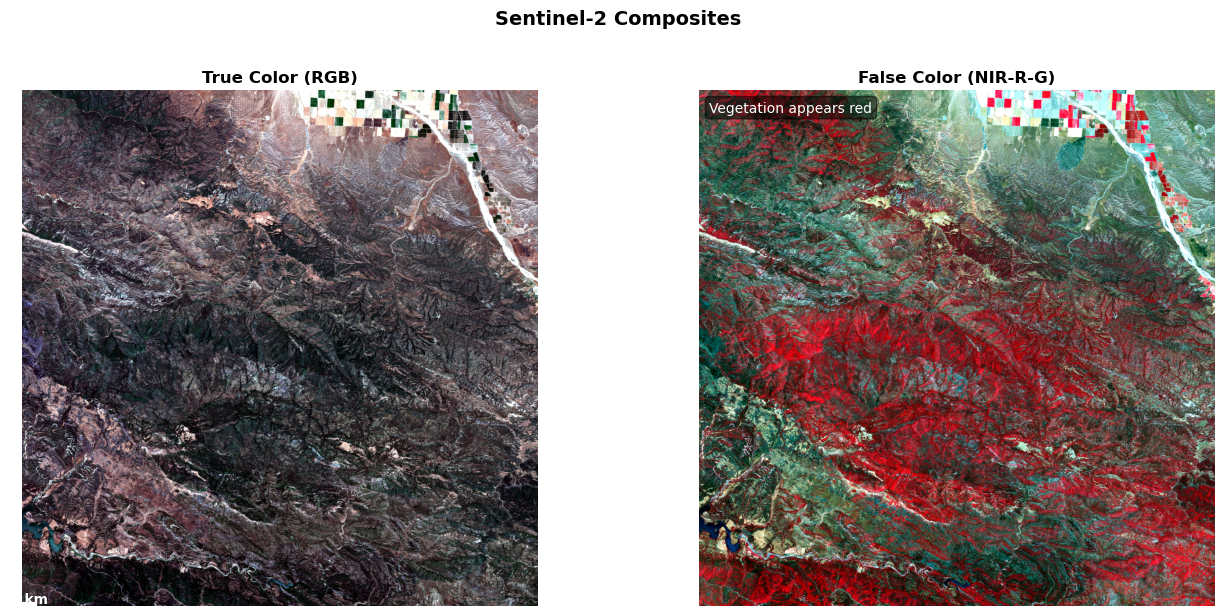

2025-10-09 13:25:27,624 - INFO - RGB composites created successfully


In [18]:
if band_data and all(k in band_data for k in ['B04', 'B03', 'B02']):
    # Create true color RGB composite using our helper function
    rgb_composite = create_rgb_composite(
        red=band_data['B04'],
        green=band_data['B03'],
        blue=band_data['B02'],
        enhance=True  # Apply contrast enhancement
    )

    logger.info(f"   RGB composite shape: {rgb_composite.shape}")

    # Create false color composite if NIR band is available
    false_color_composite = None
    if 'B08' in band_data:
        false_color_composite = create_rgb_composite(
            red=band_data['B08'],   # NIR in red channel
            green=band_data['B04'],  # Red in green channel
            blue=band_data['B03'],   # Green in blue channel
            enhance=True
        )
        logger.info(f"   False color composite created")

    # Visualize the composites
    if 'B08' in band_data:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    else:
        fig, ax1 = plt.subplots(1, 1, figsize=(8, 6))
        ax2 = None

    # True color
    ax1.imshow(rgb_composite)
    ax1.set_title('True Color (RGB)', fontsize=12, fontweight='bold')
    ax1.axis('off')

    # Add scale bar
    if 'transform' in locals() and transform:
        # Calculate pixel size in meters (approximate)
        pixel_size = abs(transform.a)  # Assuming square pixels
        scalebar_pixels = int(1000 / pixel_size)  # 1km scale bar
        if scalebar_pixels < rgb_composite.shape[1] / 4:
            ax1.plot([10, 10 + scalebar_pixels],
                    [rgb_composite.shape[0] - 20, rgb_composite.shape[0] - 20],
                    'w-', linewidth=3)
            ax1.text(10 + scalebar_pixels/2, rgb_composite.shape[0] - 30,
                    '1 km', color='white', ha='center', fontweight='bold')

    # False color if available
    if ax2 and false_color_composite is not None:
        ax2.imshow(false_color_composite)
        ax2.set_title('False Color (NIR-R-G)', fontsize=12, fontweight='bold')
        ax2.axis('off')
        ax2.text(0.02, 0.98, 'Vegetation appears red',
                transform=ax2.transAxes, color='white',
                fontsize=10, va='top',
                bbox=dict(boxstyle='round', facecolor='black', alpha=0.5))

    plt.suptitle('Sentinel-2 Composites', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

    logger.info("RGB composites created successfully")
else:
    logger.warning("Insufficient bands for RGB composite")

2025-10-09 13:25:28,949 - INFO - NDVI stats - Range: [-1.000, 0.770], Mean: 0.277
2025-10-09 13:25:29,022 - INFO - Land cover - Vegetation: 40.8%, Urban: 29.6%, Water: 0.2%


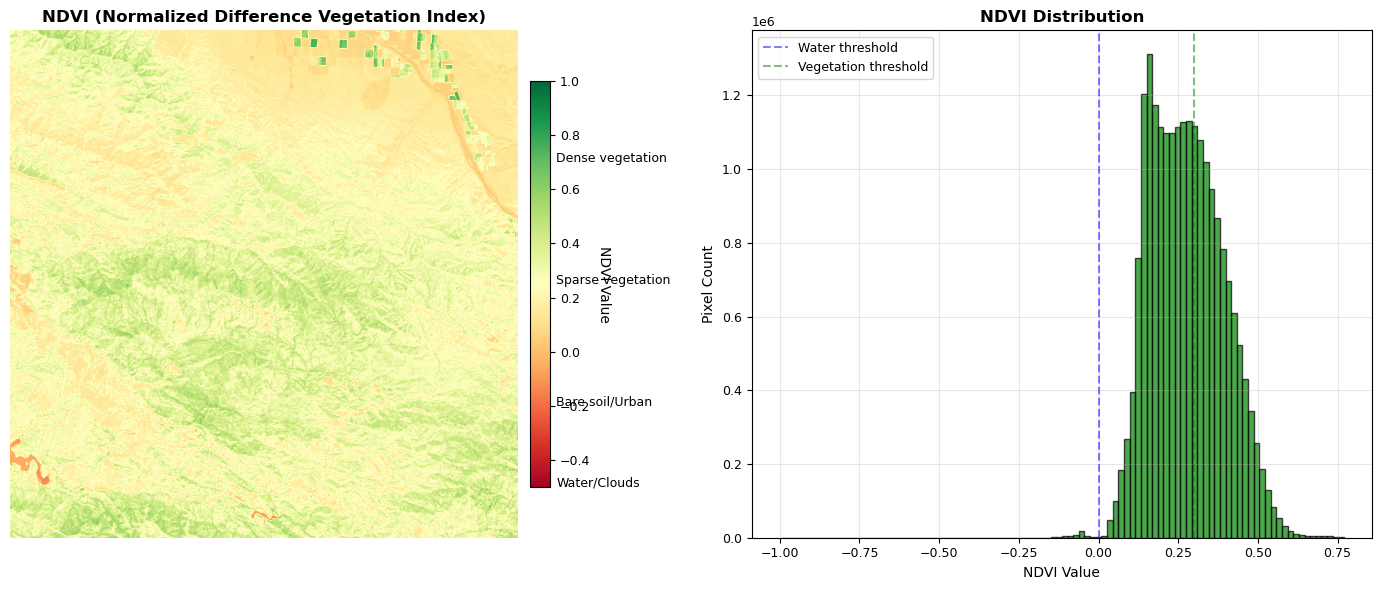

2025-10-09 13:25:30,611 - INFO - NDVI analysis complete


In [19]:
if band_data and 'B08' in band_data and 'B04' in band_data:
    # Calculate NDVI using our helper function
    ndvi = calculate_ndvi(
        nir=band_data['B08'],
        red=band_data['B04']
    )

    # Get NDVI statistics
    ndvi_stats = calculate_band_statistics(ndvi, "NDVI")

    # NDVI statistics
    logger.info(f"NDVI stats - Range: [{ndvi_stats['min']:.3f}, {ndvi_stats['max']:.3f}], Mean: {ndvi_stats['mean']:.3f}")

    # Interpret NDVI values
    vegetation_pixels = np.sum(ndvi > 0.3)
    water_pixels = np.sum(ndvi < 0)
    urban_pixels = np.sum((ndvi >= 0) & (ndvi <= 0.2))

    total_valid = ndvi_stats['valid_pixels']
    # Land cover interpretation
    veg_pct = vegetation_pixels/total_valid*100
    urban_pct = urban_pixels/total_valid*100
    water_pct = water_pixels/total_valid*100
    logger.info(f"Land cover - Vegetation: {veg_pct:.1f}%, Urban: {urban_pct:.1f}%, Water: {water_pct:.1f}%")

    # Create a detailed NDVI visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # NDVI map
    im = ax1.imshow(ndvi, cmap='RdYlGn', vmin=-0.5, vmax=1.0)
    ax1.set_title('NDVI (Normalized Difference Vegetation Index)', fontweight='bold')
    ax1.axis('off')

    # Add colorbar
    cbar = plt.colorbar(im, ax=ax1, shrink=0.8, pad=0.02)
    cbar.set_label('NDVI Value', rotation=270, labelpad=15)

    # Add interpretation labels to colorbar
    cbar.ax.text(1.3, 0.8, 'Dense vegetation', transform=cbar.ax.transAxes, fontsize=9)
    cbar.ax.text(1.3, 0.5, 'Sparse vegetation', transform=cbar.ax.transAxes, fontsize=9)
    cbar.ax.text(1.3, 0.2, 'Bare soil/Urban', transform=cbar.ax.transAxes, fontsize=9)
    cbar.ax.text(1.3, 0.0, 'Water/Clouds', transform=cbar.ax.transAxes, fontsize=9)

    # NDVI histogram
    ax2.hist(ndvi.flatten(), bins=100, color='green', alpha=0.7, edgecolor='black')
    ax2.axvline(0, color='blue', linestyle='--', alpha=0.5, label='Water threshold')
    ax2.axvline(0.3, color='green', linestyle='--', alpha=0.5, label='Vegetation threshold')
    ax2.set_xlabel('NDVI Value')
    ax2.set_ylabel('Pixel Count')
    ax2.set_title('NDVI Distribution', fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    logger.info("NDVI analysis complete")
else:
    logger.warning("NIR and Red bands required for NDVI calculation")

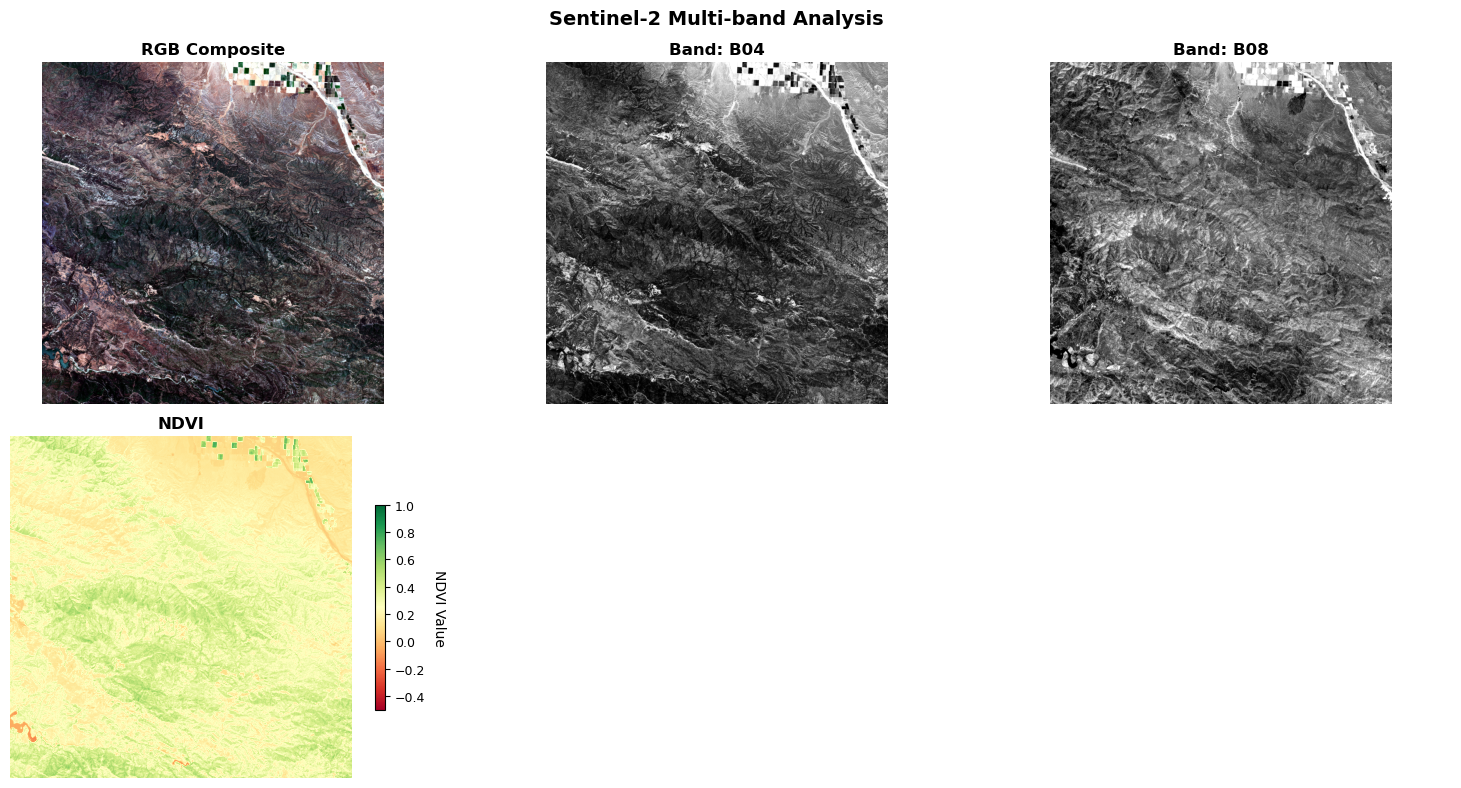

2025-10-09 13:25:37,619 - INFO - Multi-band comparison complete


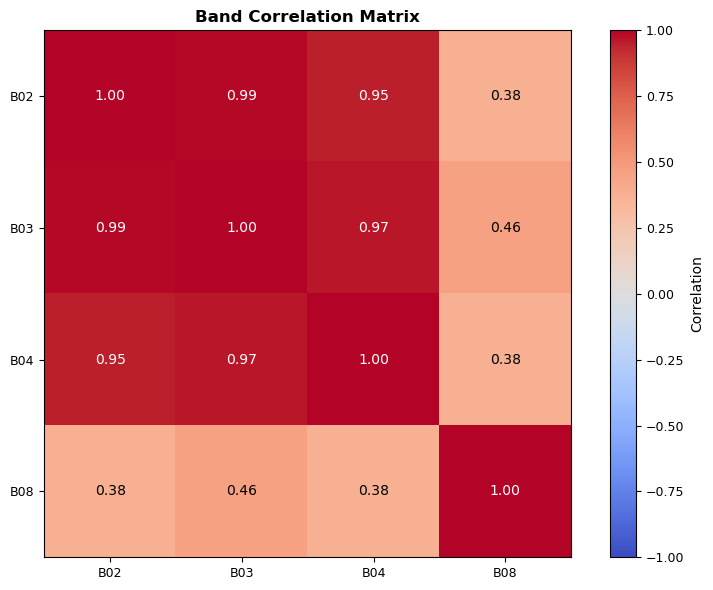

2025-10-09 13:25:39,301 - INFO - Band correlation analysis complete
2025-10-09 13:25:39,302 - INFO - Highest correlation: B03-B04 = 0.966


In [20]:
if band_data and 'rgb_composite' in locals():
    # Use our helper function for visualization
    # Filter out None values from bands dictionary
    valid_bands = {k: v for k, v in {'B04': band_data.get('B04'), 'B08': band_data.get('B08')}.items() if v is not None and isinstance(v, np.ndarray)}
    plot_band_comparison(
        bands=valid_bands,
        rgb=rgb_composite if 'rgb_composite' in locals() else None,
        ndvi=ndvi if 'ndvi' in locals() else None,
        title="Sentinel-2 Multi-band Analysis"
    )

    logger.info("Multi-band comparison complete")

# Additional analysis: Band correlations
if band_data and len(band_data) > 2:
    # Calculate band correlations

    # Create correlation matrix
    band_names = [k for k in ['B02', 'B03', 'B04', 'B08'] if k in band_data]
    if len(band_names) >= 2:
        # Flatten bands and create DataFrame
        band_df = pd.DataFrame()
        for band_name in band_names:
            band_df[band_name] = band_data[band_name].flatten()

        # Calculate correlations
        correlations = band_df.corr()

        # Plot correlation matrix
        plt.figure(figsize=(8, 6))
        im = plt.imshow(correlations, cmap='coolwarm', vmin=-1, vmax=1)
        plt.colorbar(im, label='Correlation')

        # Add labels
        plt.xticks(range(len(band_names)), band_names)
        plt.yticks(range(len(band_names)), band_names)

        # Add correlation values
        for i in range(len(band_names)):
            for j in range(len(band_names)):
                plt.text(j, i, f'{correlations.iloc[i, j]:.2f}',
                        ha='center', va='center',
                        color='white' if abs(correlations.iloc[i, j]) > 0.5 else 'black')

        plt.title('Band Correlation Matrix', fontweight='bold')
        plt.tight_layout()
        plt.show()

        logger.info("Band correlation analysis complete")
        if 'B03' in band_names and 'B04' in band_names:
            logger.info(f"Highest correlation: B03-B04 = {correlations.loc['B03', 'B04']:.3f}")